In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from tensorflow.keras.models import save_model
from collections import Counter
from wordcloud import WordCloud
import joblib
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv("C:\\Users\\Vinay\\Downloads\\archive\\AI_Human.csv")

In [3]:
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [4]:
data.shape

(487235, 2)

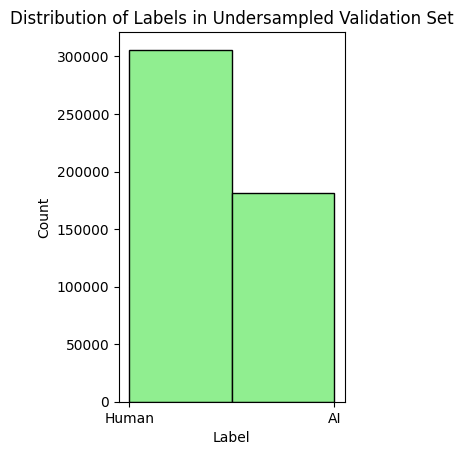

In [8]:
plt.subplot(1, 2, 2)
plt.hist(data['generated'], bins=2, color='lightgreen', edgecolor='black')
plt.title('Distribution of Labels in Undersampled Validation Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'AI'])
plt.show()

In [9]:
ai_data = data[data['generated'] == 1.]
human_data = data[data['generated'] == 0.]
sample_size = min(len(ai_data), len(human_data), 30000)

balanced_data = pd.concat([ai_data.sample(sample_size, random_state=42),
                           human_data.sample(sample_size, random_state=42)])

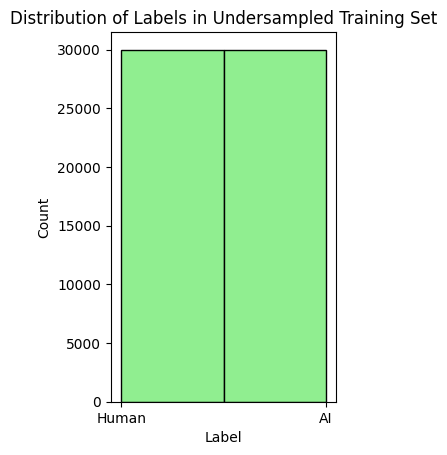

In [10]:
plt.subplot(1, 2, 2)
plt.hist(balanced_data['generated'], bins=2, color='lightgreen', edgecolor='black')
plt.title('Distribution of Labels in Undersampled Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'AI'])
plt.show()

In [11]:
# Function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    return processed_text

In [12]:
# Preprocess text data
balanced_data['processed_text'] = balanced_data['text'].apply(preprocess_text)

In [13]:
balanced_data.head()

,text,generated,processed_text
279451,I believe that online classes and video confe...,1.0,believe online class video conferencing benefi...
143852,Hhe benefits of having a positive attitude ar...,1.0,hhe benefit positive attitude numerous importa...
346790,"As an eighth grade student, I believe that pro...",1.0,eighth grade student believe problem opportuni...
32245,Title: The Facial Action Coding System: Decodi...,1.0,title facial action coding system decoding hum...
474437,A positive attitude is a powerful tool that c...,1.0,positive attitude powerful tool help individua...


#EDA

In [ ]:
essay_lengths = balanced_data['processed_text'].str.split().apply(len)
plt.figure(figsize=(10, 6))
plt.hist(essay_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Essay Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
word_counts = Counter(" ".join(balanced_data['processed_text']).split()).most_common(20)
words, counts = zip(*word_counts)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='orange')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(balanced_data['processed_text']))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()

In [ ]:
all_words = word_tokenize(" ".join(balanced_data['processed_text']))

word_freq = nltk.FreqDist(all_words)
top_words = word_freq.most_common(100)
words, counts = zip(*top_words)
ranks = range(1, len(words) + 1)

# Plot term frequency using a line plot
plt.figure(figsize=(12, 8))
plt.plot(ranks, counts, color='green', linestyle='-')
plt.title('Term Frequency of Top 100 Words')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
X = balanced_data['processed_text']
y = balanced_data['generated']

#X_test and y_test for final testing only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#xtrainmain and y_trainmain for training and x_val and y_val for validation after training
X_train_main, X_val, y_train_main, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:
balanced_data.sample(n=100, random_state=42).iloc[:, :2].to_csv('testing_only.csv', index=False)


##Cosine Similarity

In [12]:
# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train_main)
X_test_vectors = vectorizer.transform(X_val)

# Convert sparse matrices to numpy arrays
X_train_vectors = X_train_vectors.toarray()
X_test_vectors = X_test_vectors.toarray()

#Neural Network

In [ ]:
i = Input(shape=(X_train_vectors.shape[1],))
x = Dense(64, activation='relu')(i)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)


nn_model = Model(inputs=i, outputs=x)


nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = nn_model.fit(X_train_vectors, y_train_main, epochs=100, batch_size=32, validation_data=(X_test_vectors, y_val), callbacks=[early_stopping])

In [ ]:
# Save the model
save_model(nn_model, 'nn_model.keras')

In [ ]:
loss, accuracy = nn_model.evaluate(X_test_vectors, y_val)
print("Accuracy:", accuracy)

In [ ]:
#eval on completely unseen data
test_main_vectors = vectorizer.transform(X_test).toarray()
loss, accuracy = nn_model.evaluate(test_main_vectors, y_test)
print('Main Accuracy : ', accuracy)

In [13]:
from sklearn.metrics import confusion_matrix

# Predict probabilities for each class
y_pred_probabilities = nn_model.predict(test_main_vectors)

# Convert probabilities to binary predictions
y_pred = (y_pred_probabilities > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

NameError: name 'nn_model' is not defined

In [14]:
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
lr_model = LogisticRegression()

# Fit the model
lr_model.fit(X_train_vectors, y_train_main)

# Evaluate the model
train_score = lr_model.score(X_train_vectors, y_train_main)
test_score = lr_model.score(X_test_vectors, y_val)

print("Train val Accuracy:", train_score)
print("Test valAccuracy:", test_score)

Train val Accuracy: 0.9878385416666666
Test valAccuracy: 0.98125


In [15]:
test_main_vectors = vectorizer.transform(X_test).toarray()
test_main_score = lr_model.score(test_main_vectors, y_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.98125


In [ ]:
#export vectorizor and lr model
import pickle

# Save vectorizer
with open('cosine_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Save logistic regression model
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

In [ ]:
X_test.iloc[5]

In [ ]:
y_test.iloc[5]

#Bag of Words

#LR

In [ ]:

vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train_main)
X_val_vectors = vectorizer.transform(X_val)

In [ ]:
import joblib
joblib.dump(vectorizer, 'count_vectorizer.pkl')

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train_vectors, y_train_main)

In [ ]:
train_accuracy = accuracy_score(y_train_main, lr_model.predict(X_train_vectors))
val_accuracy = accuracy_score(y_val, lr_model.predict(X_val_vectors))
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

In [ ]:
test = vectorizer.transform(X_test)
test_accuracy = accuracy_score(y_test, lr_model.predict(test))
print("Testing Accuracy:", test_accuracy)

In [ ]:
joblib.dump(lr_model, 'lr_model_bof.pkl')

#SVM BOW

In [ ]:

svm_model = SVC(kernel='linear') 
svm_model.fit(X_train_vectors, y_train_main)

In [ ]:
train_accuracy = svm_model.score(X_train_vectors, y_train_main)
val_accuracy = svm_model.score(X_val_vectors, y_val)
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

In [ ]:
test = vectorizer.transform(X_test)
test_accuracy = accuracy_score(y_test, svm_model.predict(test))
print("Testing Accuracy:", test_accuracy)

In [ ]:
joblib.dump(svm_model, 'svm_bow.pkl')

#Ngram
#LR

In [ ]:
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [ ]:
X_train_vectors = ngram_vectorizer.fit_transform(X_train_main)
X_val_vectors = ngram_vectorizer.transform(X_val)

In [ ]:
joblib.dump(ngram_vectorizer, 'vectorizer_ngram.pkl')

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train_vectors, y_train_main)

In [ ]:
train_accuracy = accuracy_score(y_train_main, lr_model.predict(X_train_vectors))
val_accuracy = accuracy_score(y_val, lr_model.predict(X_val_vectors))

In [ ]:
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

In [ ]:
test = ngram_vectorizer.transform(X_test)
test_accuracy = accuracy_score(y_test, lr_model.predict(test))
print("Testing Accuracy:", test_accuracy)

In [ ]:
joblib.dump(lr_model, 'lr_ngram.pkl')

In [ ]:
X_train_vectors = ngram_vectorizer.fit_transform(X_train_main)

# Transform the validation data
X_val_vectors = ngram_vectorizer.transform(X_val)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear')  # Linear kernel for SVM
svm_model.fit(X_train_vectors, y_train_main)

# Evaluate the model
train_accuracy = svm_model.score(X_train_vectors, y_train_main)
val_accuracy = svm_model.score(X_val_vectors, y_val)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

In [ ]:
test = ngram_vectorizer.transform(X_test)
test_accuracy = accuracy_score(y_test, svm_model.predict(test))
print("Testing Accuracy:", test_accuracy)

In [ ]:
joblib.dump(svm_model, 'svc_ngram.pkl')